<h4>Raw data</h4>

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import ta
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

class Forex(object):
    def __init__(self, ticker: str, time_frame: str):
        self.ticker = ticker
        self.time_frame = time_frame

    def load_data(ticker: str, time_frame: str) -> None: # Load dataset.
        params_dic = {
         'host': 'localhost',
         'database': '/home/felipe/Desktop/python/projects/algorithmic-trading/data/forex.db'
        }
        with sqlite3.connect(f"{params_dic['database']}") as connection:
            dataset = pd.read_sql_query("SELECT * FROM "+ticker.lower()+"_"+time_frame, connection)
            return dataset

currency_pair = ['EURBRL']
#currency_pair = ['AUDCAD', 'AUDNZD', 'AUDUSD', 'CADCHF', 'EURAUD', 'EURBRL', 'EURCAD', 'EURCHF', 'EURHUF', 'EURGBP', 'EURJPY', 'EURNZD', 'EURUSD', 'GBPCAD', 'GBPCHF', 'GBPJPY', 'GBPUSD', 'GBPNZD', 'USDCAD', 'USDCHF', 'USDJPY', 'USDMXN', 'USDSGD', 'USDTRY', 'NZDCAD', 'NZDUSD', 'NZDJPY']
for currency in currency_pair:
    #time_frames = ['1d', '1wk', '1mo', '3mo'] # Intervals: “1m”, “2m”, “5m”, “15m”, “30m”, “60m”, “90m”, “1h”, “1d”, “5d”, “1wk”, “1mo”, “3mo”
    time_frames = ['1d']
    for time_frame in time_frames:
        dataset = Forex.load_data(currency, time_frame)
        print(dataset)

                     date    open    high     low   close
0     2003-12-01 00:00:00  3.4621  3.4621  3.4621  3.4621
1     2003-12-02 00:00:00  3.4151  3.4151  3.4151  3.4151
2     2003-12-03 00:00:00  3.4799  3.4799  3.4799  3.4799
3     2003-12-04 00:00:00  3.4597  3.4597  3.4597  3.4597
4     2003-12-05 00:00:00  3.4794  3.4794  3.4794  3.4794
...                   ...     ...     ...     ...     ...
4747  2022-04-18 00:00:00  5.0870  5.0870  5.0870  5.0914
4748  2022-04-19 00:00:00  5.0914  5.0914  4.9980  5.0870
4749  2022-04-20 00:00:00  5.0326  5.0664  4.9980  5.0333
4750  2022-04-21 00:00:00  5.0113  5.0511  5.0000  5.0108
4751  2022-04-22 00:00:00  5.0063  5.1423  4.9746  5.0045

[4752 rows x 5 columns]


<h4>EDA</h4>

<h4>Data Insights</h4>

<h4>PIck Model</h4>

<h4>Model</h4>

<h4>Evaluation Metrics</h4>

<h4>Featurizer</h4>

In [2]:
class FeatureEngineering(Forex):
    def __init__(self, ticker: str, time_frame: str):
        super().__init__(ticker, time_frame)

    def load_features(self): # Load features
        dataset = Forex.load_data(self.ticker, self.time_frame)
        dataset.index = dataset['date']
        CCI = ta.trend.CCIIndicator(high=dataset['high'], low=dataset['low'], close=dataset['close'], window=21) # Initialize CCI
        WMA = ta.trend.WMAIndicator(close=dataset['close'], window=21, fillna=False) # Initialize VMA
        RSI = ta.momentum.RSIIndicator(close=dataset['close'], window=21, fillna=False) # Initialize RSI
        STOCH = ta.momentum.StochasticOscillator(close=dataset['close'], high=dataset['high'], low=dataset['low'], window=21, smooth_window=3, fillna=False)
        DonchianChannel = ta.volatility.DonchianChannel(high=dataset['high'], low=dataset['low'], close=dataset['close'], window=21, fillna=False)
        dataset['EMA8'] = dataset['close'].ewm(span=8, adjust=False).mean()
        dataset['EMA21'] = dataset['close'].ewm(span=21, adjust=False).mean()
        dataset['STOCH'] = STOCH.stoch() # (STOCH) - Momentum
        dataset['RSI'] = RSI.rsi() # (RSI) - Momentum
        dataset['CCI'] = CCI.cci() # (CCI) - Trend
        dataset['WMA'] = WMA.wma() # (VMA) - Trend
        dataset['Donchian'] = DonchianChannel.donchian_channel_mband() # DonchianChannel - Volatility
        dataset['date'] = pd.to_datetime(dataset['date'])
        dataset['weekday'] = datetime.datetime.today().weekday()
        dataset['normalize'] = dataset['close'] / dataset['close'].iloc[0]
        dataset['date'] = pd.to_datetime(dataset['date'])
        dataset['day'] = dataset['date'].dt.day
        dataset['day_of_year'] = dataset['date'].dt.dayofyear 
        dataset['weekday'] = dataset['date'].apply(lambda x: x.weekday()) # Monday = 0 / Friday = 4	
        dataset['month'] = dataset['date'].dt.month
        dataset['min_21'] = dataset['close'].rolling(window=21).min()
        dataset['max_21'] = dataset['close'].rolling(window=21).max()
        dataset['std_21'] = dataset['close'].rolling(window=21).std()
        dataset['sma_21'] = dataset['close'].rolling(window=21).mean()
        dataset['ema_21'] = dataset['close'].ewm(com=21, min_periods=21).mean()
        dataset['zscore'] = stats.zscore(dataset['close'])
        for i in range(1, 4): 
            dataset[f'daily_return_{i}'] = dataset['close'].pct_change(i)
        for i in range(1, 4):
            dataset[f'difference_{i}'] = dataset['close'].diff(i)
        for i in range(1, 4):
            dataset[f'daily change%_{i}'] = ((dataset['close'] / dataset['close'].shift(i)) * 100 - 100)
        dataset['previous_close'] = dataset['close'].shift(-1)
        dataset['positive_negative'] = np.where(dataset['difference_1'] > 0, 1, 0)
        return pd.DataFrame(dataset.dropna())

currency_pair = ['AUDCAD']
#currency_pair = ['AUDCAD', 'AUDNZD', 'AUDUSD', 'CADCHF', 'EURAUD', 'EURBRL', 'EURCAD', 'EURCHF', 'EURHUF', 'EURGBP', 'EURJPY', 'EURNZD', 'EURUSD', 'GBPCAD', 'GBPCHF', 'GBPJPY', 'GBPUSD', 'GBPNZD', 'USDCAD', 'USDCHF', 'USDJPY', 'USDMXN', 'USDSGD', 'USDTRY', 'NZDCAD', 'NZDUSD', 'NZDJPY']
for currency in currency_pair:
    #time_frames = ['1d', '1wk', '1mo', '3mo'] # Intervals: “1m”, “2m”, “5m”, “15m”, “30m”, “60m”, “90m”, “1h”, “1d”, “5d”, “1wk”, “1mo”, “3mo”
    time_frames = ['1d']
    for time_frame in time_frames:
        dataset = FeatureEngineering(currency, time_frame).load_features()

print(dataset.info())
dataset.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 4771 entries, 2003-12-29 00:00:00 to 2022-04-21 00:00:00
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               4771 non-null   datetime64[ns]
 1   open               4771 non-null   float64       
 2   high               4771 non-null   float64       
 3   low                4771 non-null   float64       
 4   close              4771 non-null   float64       
 5   EMA8               4771 non-null   float64       
 6   EMA21              4771 non-null   float64       
 7   STOCH              4771 non-null   float64       
 8   RSI                4771 non-null   float64       
 9   CCI                4771 non-null   float64       
 10  WMA                4771 non-null   float64       
 11  Donchian           4771 non-null   float64       
 12  weekday            4771 non-null   int64         
 13  normalize          4771 non-null   

,date,open,high,low,close,EMA8,EMA21,STOCH,RSI,CCI,WMA,Donchian,weekday,normalize,day,day_of_year,month,min_21,max_21,std_21,sma_21,ema_21,zscore,daily_return_1,daily_return_2,daily_return_3,difference_1,difference_2,difference_3,daily change%_1,daily change%_2,daily change%_3,previous_close,positive_negative
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-16 00:00:00,2022-04-16,0.931760,0.931760,0.93176,0.931760,0.936549,0.936172,12.643708,49.998299,-151.662858,0.938258,0.94021,5,0.981958,16,106,4,0.930941,0.94695,0.003852,0.938249,0.931349,-0.335028,-0.002493,-0.004870,-0.010240,-0.002329,-0.004560,-0.009640,-0.249333,-0.487012,-1.024005,0.932669,0
2022-04-18 00:00:00,2022-04-18,0.932669,0.933277,0.92740,0.932669,0.935687,0.935854,21.844875,50.608353,-158.712256,0.937751,0.93946,0,0.982916,18,108,4,0.930941,0.94695,0.003935,0.938185,0.931409,-0.318915,0.000976,-0.001520,-0.003899,0.000909,-0.001420,-0.003651,0.097554,-0.152022,-0.389933,0.927005,1
2022-04-19 00:00:00,2022-04-19,0.927005,0.931622,0.92590,0.927005,0.933758,0.935049,4.313070,46.867133,-204.072206,0.936735,0.93871,1,0.976946,19,109,4,0.927005,0.94695,0.004367,0.937998,0.931208,-0.419318,-0.006073,-0.005103,-0.007584,-0.005664,-0.004755,-0.007084,-0.607288,-0.510327,-0.758387,0.931867,0
2022-04-20 00:00:00,2022-04-20,0.931867,0.934809,0.92872,0.931867,0.933338,0.934760,23.290441,50.186252,-112.030945,0.936177,0.93871,2,0.982070,20,110,4,0.927005,0.94695,0.004559,0.937661,0.931238,-0.333131,0.005245,-0.000860,0.000115,0.004862,-0.000802,0.000107,0.524486,-0.085988,0.011483,0.929570,1
2022-04-21 00:00:00,2022-04-21,0.929570,0.929680,0.92300,0.929570,0.932500,0.934288,23.036572,48.677832,-167.362498,0.935442,0.93726,3,0.979650,21,111,4,0.927005,0.94695,0.004780,0.937078,0.931163,-0.373849,-0.002465,0.002767,-0.003323,-0.002297,0.002565,-0.003099,-0.246493,0.276700,-0.332268,0.926610,0


<h4>Advance to Decline Ratio</h4>
<h6>Advance and Decline ratio is defined as the number of periods a stock has advanced over number of periods it has declined. This is being examined to identify if there is a trend here. For example, if there is an indication that in a particular month, stock tend to generally decline or advance.

<b>Observation</b> : There does not appear to be an evidence if Stock advancement is tied to a month.</h6>

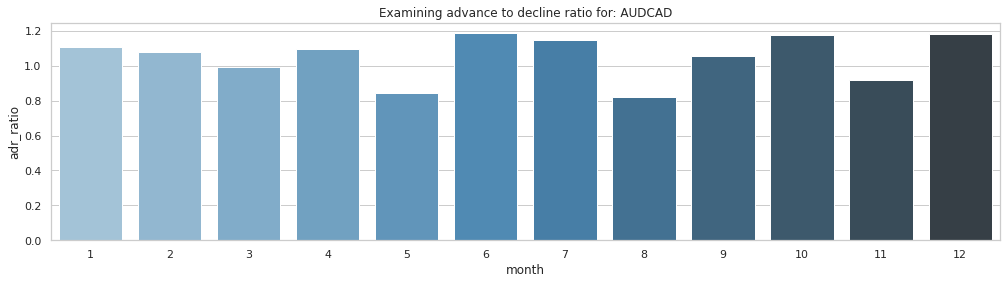

,month,advances,total,adr_ratio
0,1,220,419,1.105528
1,2,199,383,1.081522
2,3,211,423,0.995283
3,4,209,400,1.094241
4,5,181,396,0.841860
5,6,210,387,1.186441
6,7,212,397,1.145946
7,8,180,399,0.821918
8,9,197,384,1.053476
9,10,214,396,1.175824


In [3]:
sns.set(rc={'figure.figsize':(17, 4)})
sns.set_style("whitegrid")
df_stats = dataset.groupby(["month"]).agg(advances=("positive_negative", "sum"), total=("positive_negative", "count")).reset_index()
df_stats['adr_ratio'] = df_stats['advances'] / (df_stats['total'] - df_stats['advances'])
plt.title(f'Examining advance to decline ratio for: {currency}')
sns.barplot(x='month', y='adr_ratio', data=df_stats, palette="Blues_d")
plt.show()
df_stats

<h4>Split Train and Test</h4>